This notebook contains the required updates on the LG stored procedures and impact calculations in alaigment with the latest updates in the LandGriffon methodology v2.0. 

**Land footprint:** 

    Ilanduse (ha) = Sum(harvest_area_in_georegion)/sum(production_in_georegion) * Purchased_volume


**Deforestation footprint:**

    Deforestation footprint (ha) = Idef(ha/ha) * Ilanduse(ha) =>
    
    where:    
        
        I def (unitless) = Sum(Buffered_deforestation_per_ha_human_land_use * Production_commodity) / Sum(Production_commodity)
         

**GHGs (deforestation, sLUC):**

    GHG def (tco2e) = Icarbonemissions (tco2e/ha) * Ilanduse(ha) =>
    
    where:
        
        Ighgemissions (tco2e/ha) = Sum(Buffered_carbon_emissions_per_ha_human_land_use (tCO2/ha) * Production_commodity (t) / Sum(Production_commodity) (t)
        
        
**Net cropland expansion:**


    Natural ecosystems conversion risk (ha) = Inaturalconversionrisk (ha/ha) * Ilanduse(ha) =>
    
    where:
        
        Inaturalconversionrisk (ha/ha) = Sum(Natural_ecosystems_conversion_risk_per_hectare_of_land_use (ha/ha) * Production_commodity (t)) / Sum(Production_commodity(t))

**Forest landscape integrity loss:**
    
    Forest_landscape_integrity_lodd (score/yr) = I_Forest_landscape_integrity_loss (score/ha) * I_Land_use(ha)
    
    where:

        I_Forest landscape integrity loss = Sum(forest_landscape_integrity_loss(score/ha)* COmmodity_production(t)) / Total_production (t) 
    

**Water use:**

    Water_use (Mm3/yr) =  BWF (Mm3/t) * Purchase volume (t)
        
**Unsustainable water use:**

    Unsustainable water use (Mm3/yr) = Excess of water withdrawals (%) * Water use (Mm3/t) 

    where:
    
        Excess of water withdrawals (%) = (excess_of_water_withdrawals (%) * Commodity_production(t)) / Total_commodity_production(t)
        

**Nutrient Load:**

    Nutrient_load (Mm3/yr) =  GWF (Mm3/t) * Purchase volume (t)


**Excess nutrient load:**

    Nutrient load reduction (Mm3/yr) = Excess nutrient load (%) * Grey water footprint (Mm3/t)

    where:
    
        Excess nutrient load (%) = (nutrient_load (%) * Commodity_production(t)) / Total_commodity_production(t)
        
    



In [4]:
# import libraries

import matplotlib.pyplot as plt
import pandas as pd
from psycopg2.pool import ThreadedConnectionPool

In [5]:
# set env
## env file for gcs upload
env_path = ".env"
with open(env_path) as f:
    env = {}
    for line in f:
        env_key, _val = line.split("=", 1)
        env_value = _val.split("\n")[0]
        env[env_key] = env_value

# list(env.keys())

# set conexion to local ddbb
postgres_thread_pool = ThreadedConnectionPool(
    1,
    50,
    host=env["API_POSTGRES_HOST"],
    port=env["API_POSTGRES_PORT"],
    user=env["API_POSTGRES_USERNAME"],
    password=env["API_POSTGRES_PASSWORD"],
)


# get list of sourcing records to iterate:
conn = postgres_thread_pool.getconn()
cursor = conn.cursor()

In [6]:
def psql(query):
    try:
        cursor.execute(query)
        return cursor.fetchall()
    except Exception as e:
        conn.rollback()
        print(e)

In [7]:
# Define queries
# uncompact h3 georegion
SQL_GET_H3_UNCOMPACT_GEO_REGION = """
CREATE OR REPLACE FUNCTION get_h3_uncompact_geo_region(
    geo_region_id uuid,
    h3_resolution int
)
RETURNS TABLE (h3index h3index) AS 
$$
    SELECT h3_uncompact(geo_region."h3Compact"::h3index[], h3_resolution) h3index
    FROM geo_region WHERE geo_region.id = geo_region_id
$$ 
LANGUAGE SQL;
"""

# asuming that we have just a column by indicator
SQL_GET_H3_TABLE_COLUMN_FOR_INDICATORS = """
CREATE OR REPLACE FUNCTION get_h3_table_column_for_indicators(shortName text)
RETURNS TABLE (h3_table_name varchar, h3_column_name varchar, h3_resolution int) AS
$$
    SELECT h3_data."h3tableName", h3_data."h3columnName", h3_data."h3resolution"
    FROM h3_data
        INNER JOIN "indicator" ind ON ind."id" = h3_data."indicatorId"
    WHERE ind."nameCode" = shortName 
    LIMIT 1;
$$
LANGUAGE SQL;
"""
# get h3 table column for material
SQL_GET_H3_TABLE_COLUMN_FOR_MATERIAL = """
CREATE OR REPLACE FUNCTION get_h3_table_column_for_material(
    material_id uuid,
    h3_data_type material_to_h3_type_enum
)
RETURNS TABLE (h3_table_name varchar, h3_column_name varchar, h3_resolution int) AS
$$
    SELECT h3_data."h3tableName", h3_data."h3columnName", h3_data."h3resolution"
    FROM h3_data
        INNER JOIN material_to_h3 ON material_to_h3."h3DataId" = h3_data.id
    WHERE material_to_h3."materialId" = material_id 
        AND material_to_h3.type = h3_data_type
    LIMIT 1;
$$
LANGUAGE SQL;
"""
## sum h3grid over georegion
SQL_SUM_H3_GRID_OVER_GEO_REGION = (
    SQL_GET_H3_UNCOMPACT_GEO_REGION
    + """
CREATE OR REPLACE FUNCTION sum_h3_grid_over_georegion(
    geo_region_id uuid, 
    h3_resolution int,
    h3_table_name varchar, 
    h3_column_name varchar
)
RETURNS float AS
$$
    DECLARE
        sum float;
    BEGIN
        EXECUTE format(
            'SELECT sum(h3grid.%I)
                FROM
                    get_h3_uncompact_geo_region($1, $2) geo_region
                    INNER JOIN %I h3grid ON h3grid.h3index = geo_region.h3index;
            ', h3_column_name, h3_table_name)
            USING geo_region_id, h3_resolution
            INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""
)
# sum material over georegion
SQL_SUM_MATERIAL_OVER_GEO_REGION = (
    SQL_SUM_H3_GRID_OVER_GEO_REGION
    + SQL_GET_H3_TABLE_COLUMN_FOR_MATERIAL
    + """
CREATE OR REPLACE FUNCTION sum_material_over_georegion(
    geo_region_id uuid, 
    material_id uuid,
    h3_data_type material_to_h3_type_enum
)
RETURNS float AS
$$
    DECLARE
        h3_table_name varchar;
        h3_column_name varchar;
        h3_resolution integer;
        sum float;

    BEGIN
        -- Get h3data table name and column name for given material
        SELECT * INTO h3_table_name, h3_column_name, h3_resolution
        FROM get_h3_table_column_for_material(material_id, h3_data_type);

        -- Sum table column over region
        SELECT sum_h3_grid_over_georegion(
            geo_region_id,
            h3_resolution,
            h3_table_name,
            h3_column_name
        ) 
        INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""
)

## UPDATED DEFORESTATION, CLIMATE RISK FORMULAS/CARBON, NATURAL CONVERSION:
## This query is also used for the TARGET INDICATORS:
##UNSUSTAINABLE WATER USE AND NUTRIENT LOAD REDUCTION
SQL_GET_ANNUAL_COMMODITY_WEIGHTED_IMPACT_OVER_GEO_REGION = (
    SQL_GET_H3_TABLE_COLUMN_FOR_INDICATORS
    + """
CREATE OR REPLACE FUNCTION get_annual_commodity_weighted_impact_over_georegion(
    geo_region_id uuid,
    shortName text,
    material_id uuid,
    h3_data_type material_to_h3_type_enum
)
RETURNS float AS
$$
    DECLARE
        h3_resolution integer;
        indicator_h3_table_name varchar;
        indicator_h3_column_name varchar;
        h3_indicator_resolution varchar;
        material_h3_table_name varchar;
        material_h3_column_name varchar;
        sum float;
    BEGIN
    
        -- Get h3data table name, column
        SELECT * INTO indicator_h3_table_name, indicator_h3_column_name, h3_indicator_resolution
        FROM get_h3_table_column_for_indicators(shortName);
        
        -- Get h3data table name, column and resolution for the material production
        SELECT * INTO material_h3_table_name, material_h3_column_name, h3_resolution
        FROM get_h3_table_column_for_material(material_id, h3_data_type);
        
        -- Sum commodity weighted impact values
        EXECUTE format(
            'SELECT sum(h3ind.%I * h3prod.%I )
                FROM
                    get_h3_uncompact_geo_region($1, $2) geo_region
                INNER JOIN %I h3ind ON h3ind.h3index = geo_region.h3index
                INNER JOIN %I h3prod ON h3ind.h3index = h3prod.h3index;
            ', indicator_h3_column_name,
            material_h3_column_name,
            indicator_h3_table_name,
            material_h3_table_name)
            USING geo_region_id, h3_resolution
            INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""
)

## Query for computing indicator coefficient values
## UPDATED WATER QUALITY AND WATER USE
SQL_GET_INDICATOR_COEFFICIENT_IMPACT = """
CREATE OR REPLACE FUNCTION get_indicator_coefficient_impact(
    nameCode text,
    adminRegionId uuid,
    material_id uuid)
RETURNS float AS
$$
    DECLARE
        indicator_id uuid;
        value float;
    BEGIN
    
        --get indicatorId
        SELECT "id" INTO indicator_id FROM "indicator"
        WHERE "nameCode" = nameCode;
       
        -- get water footprint value by location, material and indicator
        EXECUTE format(
            'SELECT 
                COALESCE (
                    (
                    SELECT ic."value"
                    FROM "indicator_coefficient" ic
                    WHERE ic."adminRegionId" = $1 
                    AND ic."materialId" = $2 
                    AND ic."indicatorId" = $3
                    AND ic."value" IS NOT NULL
                    ),
                    (
                    SELECT ic."value"
                    FROM "indicator_coefficient" ic
                    WHERE ic."adminRegionId" IS NULL 
                    AND ic."materialId" = $2 
                    AND ic."indicatorId" = $3
                    AND ic."value" IS NOT NULL
                    )
                ) AS value;'
                )
            USING adminRegionId, material_id, indicator_id
            INTO value;
        RETURN value;
    END;
$$
LANGUAGE plpgsql;
"""

In [13]:
## Write query for new GHG emissions farm indicator

SQL_GET_H3_TABLE_COLUMN_FOR_MATERIAL_INDICATORS = """
CREATE OR REPLACE FUNCTION get_h3_table_column_for_material_indicators(nameCode text, 
materialId uuid)
RETURNS TABLE (h3_table_name varchar, h3_column_name varchar, h3_resolution int) AS
$$
    SELECT h3_data."h3tableName", h3_data."h3columnName", h3_data."h3resolution"
    FROM h3_data
        INNER JOIN "material_indicator_to_h3" mith ON mith."h3DataId" = h3_data."id"
        INNER JOIN "indicator" i ON i."id" = mith."indicatorId"
    WHERE i."nameCode" = nameCode 
    AND mith."materialId" = materialId
    LIMIT 1;
$$
LANGUAGE SQL;
"""

## UPDATED DEFORESTATION, CLIMATE RISK FORMULAS/CARBON, NATURAL CONVERSION:
## This query is also used for the TARGET INDICATORS:
##UNSUSTAINABLE WATER USE AND NUTRIENT LOAD REDUCTION
SQL_GET_ANNUAL_COMMODITY_WEIGHTED_MATERIAL_IMPACT_OVER_GEO_REGION = (
    SQL_GET_H3_TABLE_COLUMN_FOR_MATERIAL_INDICATORS
    + SQL_GET_H3_TABLE_COLUMN_FOR_MATERIAL
    + """
CREATE OR REPLACE FUNCTION get_annual_commodity_weighted_material_impact_over_georegion(
    geo_region_id uuid,
    nameCode text,
    material_id uuid,
    h3_data_type material_to_h3_type_enum
)
RETURNS float AS
$$
    DECLARE
        h3_resolution integer;
        indicator_h3_table_name varchar;
        indicator_h3_column_name varchar;
        h3_indicator_resolution varchar;
        material_h3_table_name varchar;
        material_h3_column_name varchar;
        sum float;
    BEGIN
    
        -- Get h3data table name, column for material indicator
        SELECT * INTO indicator_h3_table_name, indicator_h3_column_name, h3_indicator_resolution
        FROM get_h3_table_column_for_material_indicators(nameCode, material_id);
        
        -- Get h3data table name, column and resolution for the material production
        SELECT * INTO material_h3_table_name, material_h3_column_name, h3_resolution
        FROM get_h3_table_column_for_material(material_id, h3_data_type);
        
        -- Sum commodity weighted impact values
        EXECUTE format(
            'SELECT sum(h3ind.%I * h3prod.%I )
                FROM
                    get_h3_uncompact_geo_region($1, $2) geo_region
                INNER JOIN %I h3ind ON h3ind.h3index = geo_region.h3index
                INNER JOIN %I h3prod ON h3ind.h3index = h3prod.h3index;
            ', indicator_h3_column_name,
            material_h3_column_name,
            indicator_h3_table_name,
            material_h3_table_name)
            USING geo_region_id, h3_resolution
            INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""
)

In [14]:
pd.read_sql_query("""SELECT * FROM indicator""", conn)

/tmp/ipykernel_17293/4203819147.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query("""SELECT * FROM indicator""", conn)


,id,name,shortName,nameCode,description,status,metadata,unitId
0,936d0a9f-fe48-42b4-9433-63282d4dada5,Deforestation footprint (sLUC),Deforestation footprint (sLUC),DF_SLUC,The deforestation footprint (sLUC) indicator q...,active,"{'name': 'Deforestation footprint (sLUC)', 'un...",6970f9b8-eba0-4fee-b6ee-2723ce6604d4
1,157b5f22-916b-4981-84c7-f6607ec65445,GHG emissions from deforestation (sLUC),"GHGs (deforestation, sLUC)",GHG_DEF_SLUC,The GHG emissions from deforestation (sLUC) in...,active,{'name': 'GHG emissions from deforestation (sL...,a0e8110c-fbde-4c8c-ac19-f0f69078b96b
2,3a718205-10c1-4e11-81b3-cb8965e378c7,Biodiversity importance of natural ecosystems ...,Forest landscape integrity loss,FLIL,The biodiversity importance of natural ecosyst...,active,{'name': 'Biodiversity importance of natural e...,1129394b-6baa-41dd-9409-80d808dbc32e
3,1994e7bf-5442-4061-ba48-6320574263ad,GHG emissions from farm management,GHGs (farm management),GHG_FARM,The GHG emissions from farm management indicat...,inactive,"{'name': 'GHG emissions from farm management',...",a0e8110c-fbde-4c8c-ac19-f0f69078b96b
4,5c595ac7-f144-485f-9f32-601f6faae9fe,Land use footprint for production,Land footprint,LF,The land use footprint for production indicato...,active,"{'name': 'Land use footprint for production', ...",6970f9b8-eba0-4fee-b6ee-2723ce6604d4
5,ffdd6f19-6737-4a10-9d36-5243d3f14b45,Excess surface or groundwater use,Unsustainable water use,UWU,The excess surface or groundwater use indicato...,active,"{'name': 'Excess surface or groundwater use', ...",9c0da38a-6371-4c79-879b-218fc39c4700
6,a39394be-ad57-41bc-9c2c-be0949ec6193,Excess freshwater nutrient load assimilation v...,Excess nutrient load,ENL,The excess freshwater nutrient load assimilati...,active,{'name': 'Excess freshwater nutrient load assi...,9c0da38a-6371-4c79-879b-218fc39c4700
7,5c133ba4-da24-46db-9c6c-ece7520f01b0,Cropland expansion in natural ecosystems,Net cropland expansion,NCE,The annual average area of cropland expansion ...,active,{'name': 'Cropland expansion in natural ecosys...,6970f9b8-eba0-4fee-b6ee-2723ce6604d4
8,9c2124c7-5df0-40d5-962e-d35480d48cd3,Surface or groundwater use,Water use,WU,The surface or groundwater use indicator estim...,active,"{'name': 'Surface or groundwater use', 'units'...",9c0da38a-6371-4c79-879b-218fc39c4700
9,d5f945c9-8636-45a2-a7c9-67a1dc8e687a,Freshwater nutrient load assimilation volume,Nutrient load,NL,The freshwater nutrient load assimilation volu...,active,{'name': 'Freshwater nutrient load assimilatio...,9c0da38a-6371-4c79-879b-218fc39c4700


In [16]:
sourcing_records = pd.read_sql_query(
    SQL_GET_ANNUAL_COMMODITY_WEIGHTED_MATERIAL_IMPACT_OVER_GEO_REGION
    + """
    SELECT 
        sr.id,
        sr.tonnage,
        sl.production,
        sl.harvest,
        sl.raw_def_footprint_per_tonne_annual,
        sl.raw_net_cropland_expansion_per_tonne_annual,
        sl.raw_ghg_emissions_def_per_tonne_annual,
        sl.raw_flil_per_tonne_annual,
        sl.raw_water_use,
        sl.raw_uwu_per_tonne_annual,
        sl.raw_nutrient_load,
        sl.raw_enl_per_tonne_annual
        --sl.raw_ghg_emissions_farm_per_tonne_annual
    FROM 
        sourcing_records sr
    INNER JOIN
        (
        SELECT 
            id,
            "geoRegionId",
            "locationCountryInput",
            sum_material_over_georegion(
                "geoRegionId", "materialId", 'producer'
            ) as production,
            sum_material_over_georegion(
                "geoRegionId", "materialId", 'harvest'
            ) as harvest,
            get_annual_commodity_weighted_impact_over_georegion(
                "geoRegionId", 'DF_SLUC', "materialId", 'producer'
            ) raw_def_footprint_per_tonne_annual,
            get_annual_commodity_weighted_impact_over_georegion(
                "geoRegionId", 'NCE', "materialId", 'producer'
            ) raw_net_cropland_expansion_per_tonne_annual,
            get_annual_commodity_weighted_impact_over_georegion(
                "geoRegionId",'GHG_DEF_SLUC', "materialId", 'producer'
            ) raw_ghg_emissions_def_per_tonne_annual,
            get_annual_commodity_weighted_impact_over_georegion(
                "geoRegionId",'UWU', "materialId", 'producer'
            ) raw_uwu_per_tonne_annual,
            get_annual_commodity_weighted_impact_over_georegion(
                "geoRegionId",'ENL', "materialId", 'producer'
            ) raw_enl_per_tonne_annual,
            get_annual_commodity_weighted_impact_over_georegion(
                "geoRegionId",'FLIL', "materialId", 'producer'
            ) raw_flil_per_tonne_annual,
            get_indicator_coefficient_impact(
                'WU', "adminRegionId", "materialId"
            ) raw_water_use,
            get_indicator_coefficient_impact(
                'NL', "adminRegionId", "materialId"
            ) raw_nutrient_load
            --get_annual_commodity_weighted_material_impact_over_georegion(
            --    "geoRegionId",'GHG_FARM', "materialId", 'producer'
            --) raw_ghg_emissions_farm_per_tonne_annual
        FROM
            sourcing_location
        ) AS sl
        ON sr."sourcingLocationId" = sl."id"
        """,
    conn,
)

sourcing_records.head()

/tmp/ipykernel_17293/2847287075.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sourcing_records = pd.read_sql_query( SQL_GET_ANNUAL_COMMODITY_WEIGHTED_MATERIAL_IMPACT_OVER_GEO_REGION +


,id,tonnage,production,harvest,raw_def_footprint_per_tonne_annual,raw_net_cropland_expansion_per_tonne_annual,raw_ghg_emissions_def_per_tonne_annual,raw_flil_per_tonne_annual,raw_water_use,raw_uwu_per_tonne_annual,raw_nutrient_load,raw_enl_per_tonne_annual
0,cd61b61e-bed0-47a7-8ae4-b129a3929c2f,1101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cc9c4e0c-3bdb-4bc0-8c21-7841f2879819,7298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ced1f2ce-76ce-43af-b31d-61a34d3cc04c,7807.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,732104e5-65df-4635-8581-4e601bf3618c,9480.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7085e20c-6351-48e7-bb36-3c54303d105d,2696.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
sourcing_records.dropna().head()

,id,tonnage,production,harvest,raw_def_footprint_per_tonne_annual,raw_net_cropland_expansion_per_tonne_annual,raw_ghg_emissions_def_per_tonne_annual,raw_flil_per_tonne_annual,raw_water_use,raw_uwu_per_tonne_annual,raw_nutrient_load,raw_enl_per_tonne_annual
0,cd61b61e-bed0-47a7-8ae4-b129a3929c2f,1101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cc9c4e0c-3bdb-4bc0-8c21-7841f2879819,7298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ced1f2ce-76ce-43af-b31d-61a34d3cc04c,7807.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,732104e5-65df-4635-8581-4e601bf3618c,9480.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7085e20c-6351-48e7-bb36-3c54303d105d,2696.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Land footprint impact
sourcing_records["land_per_ton"] = sourcing_records["harvest"] / sourcing_records["production"]
sourcing_records["land_footprint"] = sourcing_records["land_per_ton"] * sourcing_records["tonnage"]

# DEFORESTATION FOOTPRINT:
# 1. Calculate the raw deforestation footprint.
# 2. Divide the raw deforestation by the total production.
# 3. Multiply that by the land footprint impact of my material
sourcing_records["raw_deforestation_footprint"] = (
    sourcing_records["raw_def_footprint_per_tonne_annual"] / sourcing_records["production"]
)
sourcing_records["deforestation_footprint"] = (
    sourcing_records["raw_deforestation_footprint"] * sourcing_records["land_footprint"]
)

# GHG EMISSIONS DEFORESTATION:
# 1. Calculate the total carbon emissions in georegion
# 2. Multiply the carbon emissions by the commodity production
# 3. Multiply that by the land footprint impact
sourcing_records["raw_emissions"] = (
    sourcing_records["raw_ghg_emissions_def_per_tonne_annual"] / sourcing_records["production"]
)
sourcing_records["ghg_emissions_def"] = (
    sourcing_records["raw_emissions"] * sourcing_records["land_footprint"]
)

# GHG EMISSIONS FARM:
# 1. Calculate the total carbon emissions in georegion
# 2. Multiply the carbon emissions by the commodity production
# 3. Multiply that by the land footprint impact
# sourcing_records["raw_emissions_farm"] = (
#    sourcing_records["raw_ghg_emissions_farm_per_tonne_annual"] / sourcing_records["production"]
# )
# sourcing_records["ghg_emissions_farm"] = (
#    sourcing_records["raw_emissions_farm"] * sourcing_records["tonnage"]
# )


# NET CROPLAND EXPANAION
# 1. Calculate the total net cropland expansion by hectare of human land use
# 2. Multiply the net cropland expansion by the commodity production
# 3. Multiply  that by the landfootprint impact
sourcing_records["raw_net_cropland_expansion"] = (
    sourcing_records["raw_net_cropland_expansion_per_tonne_annual"] / sourcing_records["production"]
)
sourcing_records["net_cropland_expansion"] = (
    sourcing_records["raw_net_cropland_expansion"] * sourcing_records["land_footprint"]
)

# FOREST LANDSCAPE INTEGRITY LOSS
# 1. Calculate the total raw forest landscape integrity loss by hectare of human land use
# 2. Multiply the raw forest landscape integrity loss by the commodity production
# 3. Multiply the weighted raw forest landscape integrity loss by the land footprint impact
sourcing_records["raw_forest_landscape_integrity_loss"] = (
    sourcing_records["raw_flil_per_tonne_annual"] / sourcing_records["production"]
)
sourcing_records["forest_landscape_integrity_loss"] = (
    sourcing_records["raw_forest_landscape_integrity_loss"] * sourcing_records["land_footprint"]
)

# WATER USE CALCULATION
# 1. Obtain the raw water use by tonne in relation to the georegion and commodity
# 2. Multiply the raw water use by the tonnes sourced
sourcing_records["water_use"] = sourcing_records["raw_water_use"] * sourcing_records["tonnage"]

# NUTRIENT LOAD CALCULATION
# 1. Obtain the raw nutrient loas by tonne in relation to the georegion and commodity
# 2. Multiply that by the landfootprint impact
sourcing_records["nutrient_load"] = (
    sourcing_records["raw_nutrient_load"] * sourcing_records["tonnage"]
)

# UNSUSTAINABLE WATER USE (m3)
# 1. Obtain the weighted percentage of excess of water withdrawals
# by dividing the raw unsustainable water use by the total commodity production
# 2  Devide the weighted percentage by 100 to obtain the percentage
# 3. Multiply the weighted excess of water withdrawals by the total water use indicator
sourcing_records["unsustianable_water_use"] = (
    sourcing_records["raw_uwu_per_tonne_annual"] * sourcing_records["water_use"]
) / (100 * sourcing_records["production"])

# NUTRIENT LOAD REDUCTION (m3)
# 1. Obtain the weighted percentage of excess of nutrient load
# by dividing the raw excess of nutrient load by the total commodity production
# 2. Devide the weighted percentage by 100 to obtain the percentage
# 2. Multiply the weighted excess of nutrient load by the total nutrient load indicator
sourcing_records["nutrient_load_reduction"] = (
    sourcing_records["raw_enl_per_tonne_annual"] * sourcing_records["nutrient_load"]
) / (100 * sourcing_records["production"])

sourcing_records.head()

,id,tonnage,production,harvest,raw_def_footprint_per_tonne_annual,raw_net_cropland_expansion_per_tonne_annual,raw_ghg_emissions_def_per_tonne_annual,raw_flil_per_tonne_annual,raw_water_use,raw_uwu_per_tonne_annual,...,raw_emissions,ghg_emissions_def,raw_net_cropland_expansion,net_cropland_expansion,raw_forest_landscape_integrity_loss,forest_landscape_integrity_loss,water_use,nutrient_load,unsustianable_water_use,nutrient_load_reduction
0,cd61b61e-bed0-47a7-8ae4-b129a3929c2f,1101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1,cc9c4e0c-3bdb-4bc0-8c21-7841f2879819,7298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,ced1f2ce-76ce-43af-b31d-61a34d3cc04c,7807.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,732104e5-65df-4635-8581-4e601bf3618c,9480.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
4,7085e20c-6351-48e7-bb36-3c54303d105d,2696.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [16]:
sourcing_records.dropna()

,id,tonnage,production,harvest,raw_def_footprint_per_tonne_annual,raw_net_cropland_expansion_per_tonne_annual,raw_ghg_emissions_def_per_tonne_annual,raw_flil_per_tonne_annual,raw_water_use,raw_uwu_per_tonne_annual,...,raw_emissions,ghg_emissions_def,raw_net_cropland_expansion,net_cropland_expansion,raw_forest_landscape_integrity_loss,forest_landscape_integrity_loss,water_use,nutrient_load,unsustianable_water_use,nutrient_load_reduction
11,fb1a4b72-1b82-4df9-a036-c9b3532d384c,8687.0,8.963334e+03,2.786306e+03,164.122391,25.864861,6.252494e+04,0.636712,0.000000,2455.418217,...,6.975634,18837.044020,0.002886,7.792371,0.000071,0.191824,0.000000,0.000000,0.000000,0.0
12,1d8244fd-396e-4786-9fe9-e72cf83e2d39,7929.0,8.963334e+03,2.786306e+03,164.122391,25.864861,6.252494e+04,0.636712,0.000000,2455.418217,...,6.975634,17193.383451,0.002886,7.112433,0.000071,0.175086,0.000000,0.000000,0.000000,0.0
13,2288575b-4fdf-485b-adf6-44a23653bcd9,5730.0,8.963334e+03,2.786306e+03,164.122391,25.864861,6.252494e+04,0.636712,0.000000,2455.418217,...,6.975634,12425.033065,0.002886,5.139897,0.000071,0.126528,0.000000,0.000000,0.000000,0.0
14,d428ef8e-56ba-4378-a1e2-54c024aa1555,9044.0,8.963334e+03,2.786306e+03,164.122391,25.864861,6.252494e+04,0.636712,0.000000,2455.418217,...,6.975634,19611.169117,0.002886,8.112605,0.000071,0.199707,0.000000,0.000000,0.000000,0.0
15,4582d5af-4d81-4a54-b562-00faa0676290,6533.0,8.963334e+03,2.786306e+03,164.122391,25.864861,6.252494e+04,0.636712,0.000000,2455.418217,...,6.975634,14166.272428,0.002886,5.860200,0.000071,0.144260,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14449,2340d192-ab39-4553-a83f-3f5626af3740,972.0,8.732908e+06,2.280675e+06,47003.859375,472962.118128,8.846460e+06,42590.714844,0.445931,812070.094434,...,1.013003,257.146944,0.054159,13.747958,0.004877,1.238017,433.444936,237.216817,0.403059,0.0
14450,d3c98ef7-4f4b-477f-8dd6-f582a9b1777e,8574.0,8.732908e+06,2.280675e+06,47003.859375,472962.118128,8.846460e+06,42590.714844,0.445931,812070.094434,...,1.013003,2268.290019,0.054159,121.270571,0.004877,10.920537,3823.412425,2092.486613,3.555378,0.0
14451,1875ac3e-ab81-4a0b-936e-b4909d5c60ca,557.0,8.732908e+06,2.280675e+06,47003.859375,472962.118128,8.846460e+06,42590.714844,0.445931,812070.094434,...,1.013003,147.356839,0.054159,7.878202,0.004877,0.709440,248.383569,135.935974,0.230971,0.0
14452,07f8c958-e121-499c-92a2-9630c23cd1fa,6524.0,8.732908e+06,2.280675e+06,47003.859375,472962.118128,8.846460e+06,42590.714844,0.445931,812070.094434,...,1.013003,1725.953357,0.054159,92.275391,0.004877,8.309492,2909.253868,1592.183656,2.705305,0.0


In [17]:
# Double checking
print(sourcing_records.columns)
sourcing_records.to_csv("../../data/QA/update_formulas_LGv20_09_2023.csv")

Index(['id', 'tonnage', 'production', 'harvest',
       'raw_def_footprint_per_tonne_annual',
       'raw_net_cropland_expansion_per_tonne_annual',
       'raw_ghg_emissions_def_per_tonne_annual', 'raw_flil_per_tonne_annual',
       'raw_water_use', 'raw_uwu_per_tonne_annual', 'raw_nutrient_load',
       'raw_enl_per_tonne_annual', 'land_per_ton', 'land_footprint',
       'raw_deforestation_footprint', 'deforestation_footprint',
       'raw_emissions', 'ghg_emissions_def', 'raw_net_cropland_expansion',
       'net_cropland_expansion', 'raw_forest_landscape_integrity_loss',
       'forest_landscape_integrity_loss', 'water_use', 'nutrient_load',
       'unsustianable_water_use', 'nutrient_load_reduction'],
      dtype='object')


In [18]:
# Normlize the columns by the tonnage so we can compare results
sourcing_records["norm_land_footprint"] = (
    sourcing_records["land_footprint"] / sourcing_records["tonnage"]
)
sourcing_records["nm_deforestation_footprint"] = (
    sourcing_records["deforestation_footprint"] / sourcing_records["tonnage"]
)
sourcing_records["nm_ghg_emissions"] = (
    sourcing_records["ghg_emissions_def"] / sourcing_records["tonnage"]
)
sourcing_records["nm_net_cropland_expansion"] = (
    sourcing_records["net_cropland_expansion"] / sourcing_records["tonnage"]
)
sourcing_records["nm_flil"] = (
    sourcing_records["forest_landscape_integrity_loss"] / sourcing_records["tonnage"]
)
sourcing_records["nm_water_use"] = sourcing_records["water_use"] / sourcing_records["tonnage"]
sourcing_records["nm_nutrient_load"] = (
    sourcing_records["nutrient_load"] / sourcing_records["tonnage"]
)
sourcing_records["nm_uwu"] = (
    sourcing_records["unsustianable_water_use"] / sourcing_records["tonnage"]
)
sourcing_records["nm_nlr"] = (
    sourcing_records["nutrient_load_reduction"] / sourcing_records["tonnage"]
)
sourcing_records.head()

,id,tonnage,production,harvest,raw_def_footprint_per_tonne_annual,raw_net_cropland_expansion_per_tonne_annual,raw_ghg_emissions_def_per_tonne_annual,raw_flil_per_tonne_annual,raw_water_use,raw_uwu_per_tonne_annual,...,nutrient_load_reduction,norm_land_footprint,nm_deforestation_footprint,nm_ghg_emissions,nm_net_cropland_expansion,nm_flil,nm_water_use,nm_nutrient_load,nm_uwu,nm_nlr
0,efee8975-84fb-4aec-94e7-938da662f17d,3234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1,5c830838-d035-437d-859d-5d8a34399bc4,4328.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,f8887f90-f675-42bb-b0be-f176c0358862,2260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,aa7416c7-3f6a-4da3-a2ac-11e7faef960c,2191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
4,530bf195-a3db-42c0-a3f4-a0a7d490cb3f,2344.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


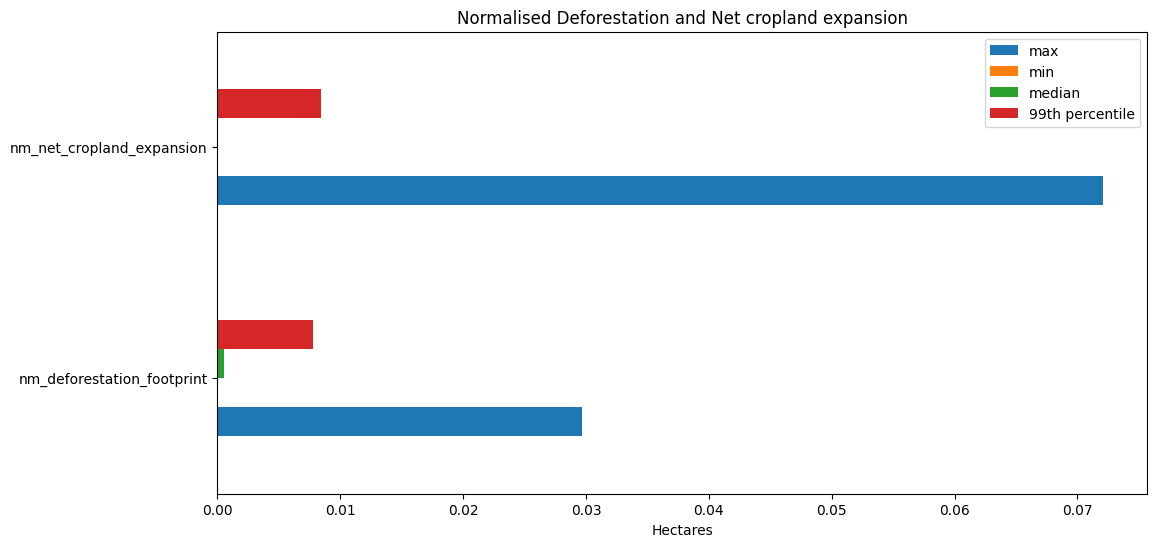

In [19]:
# Plot the indicators measured as ha which are interconnected
columns_to_plot = ["nm_deforestation_footprint", "nm_net_cropland_expansion"]
subset_df = sourcing_records[columns_to_plot].agg(
    ["max", "min", "median", lambda x: x.quantile(0.99)]
)

subset_df.T.rename(columns={"<lambda>": "99th percentile"}).plot(kind="barh", figsize=(12, 6))
plt.title("Normalised Deforestation and Net cropland expansion")
plt.xlabel("Hectares")
plt.show()

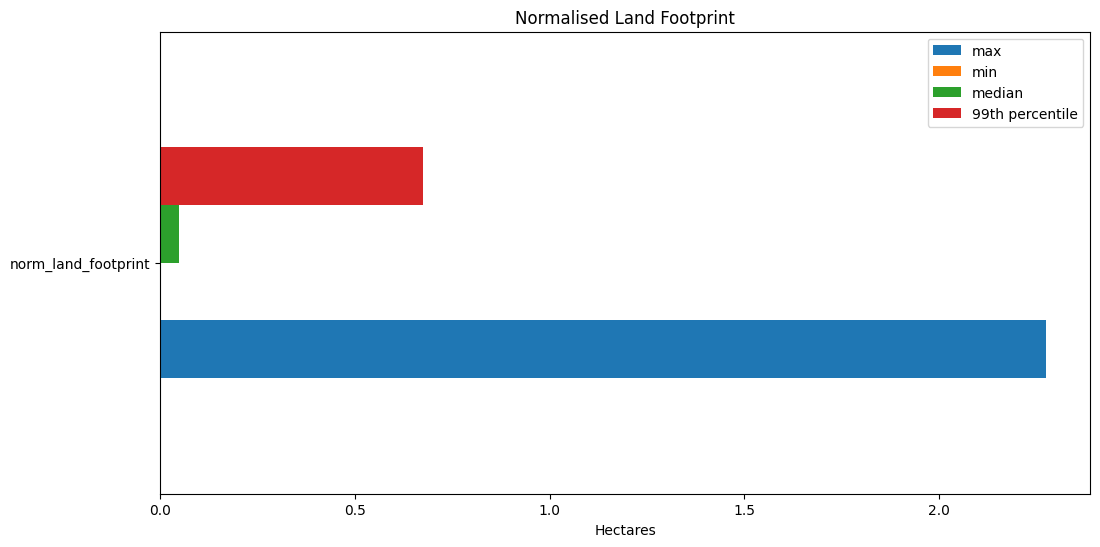

In [20]:
# Plot land footprint
columns_to_plot = ["norm_land_footprint"]
subset_df = sourcing_records[columns_to_plot].agg(
    ["max", "min", "median", lambda x: x.quantile(0.99)]
)

subset_df.T.rename(columns={"<lambda>": "99th percentile"}).plot(kind="barh", figsize=(12, 6))
plt.title("Normalised Land Footprint")
plt.xlabel("Hectares")
plt.show()

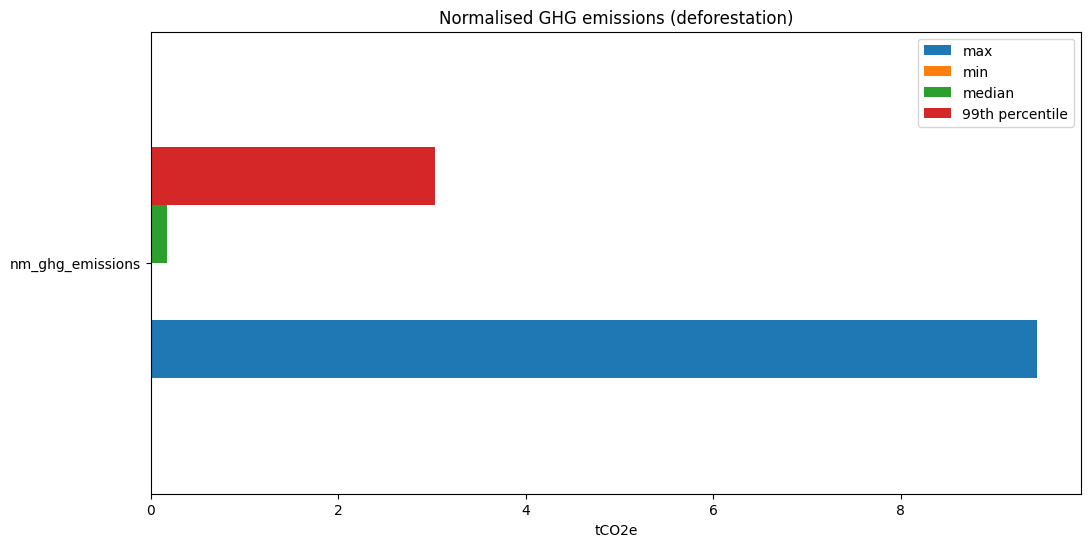

In [21]:
# Plot ghg emissions
columns_to_plot = ["nm_ghg_emissions"]
subset_df = sourcing_records[columns_to_plot].agg(
    ["max", "min", "median", lambda x: x.quantile(0.99)]
)

subset_df.T.rename(columns={"<lambda>": "99th percentile"}).plot(kind="barh", figsize=(12, 6))
plt.title("Normalised GHG emissions (deforestation)")
plt.xlabel("tCO2e")
plt.show()

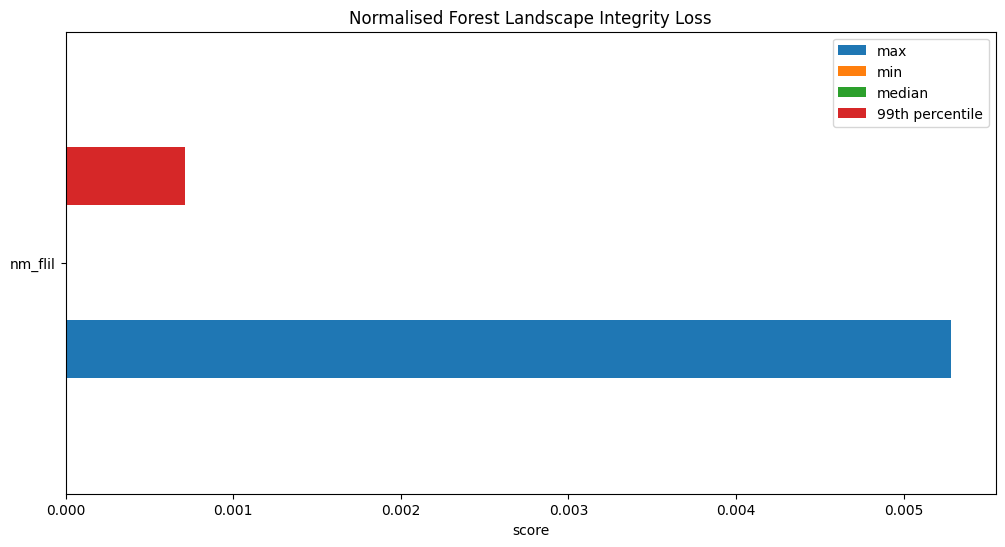

In [22]:
# Plot forest landscape integrity loss
columns_to_plot = ["nm_flil"]
subset_df = sourcing_records[columns_to_plot].agg(
    ["max", "min", "median", lambda x: x.quantile(0.99)]
)

subset_df.T.rename(columns={"<lambda>": "99th percentile"}).plot(kind="barh", figsize=(12, 6))
plt.title("Normalised Forest Landscape Integrity Loss")
plt.xlabel("score")
plt.show()

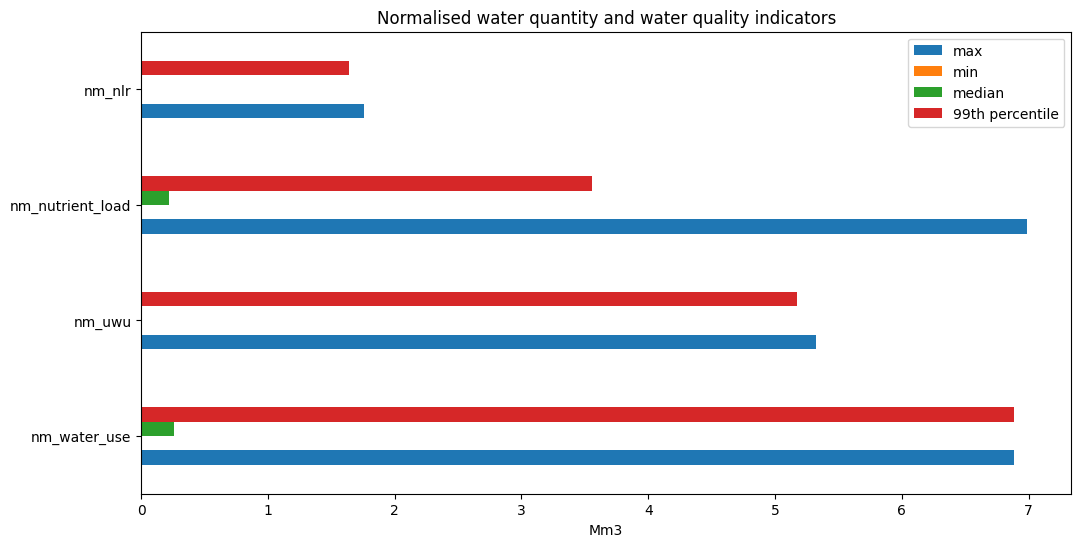

In [23]:
# Plot forest landscape integrity loss
columns_to_plot = ["nm_water_use", "nm_uwu", "nm_nutrient_load", "nm_nlr"]
subset_df = sourcing_records[columns_to_plot].agg(
    ["max", "min", "median", lambda x: x.quantile(0.99)]
)

subset_df.T.rename(columns={"<lambda>": "99th percentile"}).plot(kind="barh", figsize=(12, 6))
plt.title("Normalised water quantity and water quality indicators")
plt.xlabel("Mm3")
plt.show()